In [ ]:
### Introduction and Initial Set Up
We'll use blessing test to build our reviews multi classifier

In [63]:
import sagemaker
from sagemaker import get_execution_role
import json
import boto3

sess = sagemaker.Session()

role = get_execution_role()
print(role) 

bucket = 'phdata-nlp-s3-bucket' 
print(bucket)
prefix = 'blazingtext/supervised' 

arn:aws:iam::023375022819:role/service-role/AmazonSageMaker-ExecutionRole-20191220T213935
phdata-nlp-s3-bucket


### Data Preparation



In [64]:
!aws s3 cp s3://phdata-nlp-s3-bucket/labelled_reviews_short.csv `pwd`


download: s3://phdata-nlp-s3-bucket/labelled_reviews_short.csv to ./labelled_reviews_short.csv


In [65]:
!head labelled_reviews_short.csv -n 3

,title_and_review,topic
0,"__label__unsatisfied Umm....Get a life....a REAL one This is corny. People...go get some excercise. Talk to REAL people. Visit REAL places. Throw a REAL party. Dont buy this game and then sit around letting the whole REAL world go by. Seriously, if you arent twelve years old with a 7 pm curfew, there is no reason to sit around doing this nonsense all day.",unsatisfied
1,"__label__book summary Yukkk! Please don't think this is really Dean Koontz The Door to December is the newest Koontz audio book in my local library system and I thought it would be up up his usual standards. Was I mistaken! Creepy but not mysterious should be an oxymoron but that describes this book. Child abuse and S&M; does not really make for entertainment, even in Koontz's hands. I felt depressed after finishing this book because there seemed no hope for the characters nor purpose to the story except for a generalized fear of the government.After Odd Thomas, The Face, Watchers, and other 

Inspection 

In [67]:
import pandas as pd


reviews = pd.read_csv('labelled_reviews_short.csv')['title_and_review']


In [76]:
#split data into 70% train and 30% test
train_size = round(0.7 * len(reviews))
train = reviews[:train_size]
test = reviews[train_size:]
 
train.to_csv("reviews.train.csv", index=False, header=True)
test.to_csv("reviews.test.csv", index=False, header=True)

print("training set size = " + str(len(train) ) + "\t\t test set size =" + str ( len(test) ) )

training set size = 252000		 test set size =108000


In [77]:
!head reviews.train.csv -n 3


title_and_review
"__label__unsatisfied Umm....Get a life....a REAL one This is corny. People...go get some excercise. Talk to REAL people. Visit REAL places. Throw a REAL party. Dont buy this game and then sit around letting the whole REAL world go by. Seriously, if you arent twelve years old with a 7 pm curfew, there is no reason to sit around doing this nonsense all day."
"__label__book summary Yukkk! Please don't think this is really Dean Koontz The Door to December is the newest Koontz audio book in my local library system and I thought it would be up up his usual standards. Was I mistaken! Creepy but not mysterious should be an oxymoron but that describes this book. Child abuse and S&M; does not really make for entertainment, even in Koontz's hands. I felt depressed after finishing this book because there seemed no hope for the characters nor purpose to the story except for a generalized fear of the government.After Odd Thomas, The Face, Watchers, and other Koontz wonders, I was b

In [78]:
!head reviews.test.csv  -n 3


title_and_review
__label__unsatisfied Good begining but near end it got boring that is all I have to say. I never even finished the book it was too boring. The beginning is cool but the end (no offense) sounds like an episode of Dora the Explorer. A magical merry go round......seriously? I could just here the Dora the Explorer theme song in my head as I was reading it....do do do do do dora do do do do do dora dora dora dora the explorer.......
"__label__media LMAO!!!!! Oh...oh my god....when I listened to those samples I just had to say something. I was shocked at the number of people who thought this album 'rocked' or whatever. It's so bad...it's good. I laughed for over 3 hours listening to 'It's Halloween'....what the hell is this? Drums being played at random while the guitarist (i feel bad giving her this name) played worse then maybe my dog, while the bloody vocalist is drunk and on drugs or something! I mean come on people, what's with this stupid [stuff]?Never in my life have 

## Data Preprocessing


Download and import pre pre processing libraries: nltk tokenizer and other libraries

In [80]:
from random import shuffle
import multiprocessing
from multiprocessing import Pool
import csv
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [81]:
def transform_instance(row):
    cur_row = []
    cur_row.extend(nltk.word_tokenize(row[0].lower()))
    return cur_row

In [82]:
def preprocess(input_file, output_file, keep=1):
    all_rows = []
    with open(input_file, 'r') as csvinfile:
        csv_reader = csv.reader(csvinfile, delimiter=',')
        for row in csv_reader:
            all_rows.append(row)
    shuffle(all_rows)
    all_rows = all_rows[:int(keep*len(all_rows))]
    pool = Pool(processes=multiprocessing.cpu_count())
    transformed_rows = pool.map(transform_instance, all_rows)
    pool.close() 
    pool.join()
    
    with open(output_file, 'w') as csvoutfile:
        csv_writer = csv.writer(csvoutfile, delimiter=' ', lineterminator='\n')
        csv_writer.writerows(transformed_rows)

In [83]:
%%time

# Preparing the training dataset
preprocess('reviews.train.csv', 'reviews.train', keep=1)
        
# Preparing the validation dataset        
preprocess('reviews.test.csv', 'reviews.validation')

CPU times: user 13.7 s, sys: 1.99 s, total: 15.7 s
Wall time: 2min 1s


In [84]:
!head reviews.train  -n 3


__label__unsatisfied nelly nelly sucks now , he used to be good . but now he 's a stupid pop rapper and he 's singing like a faggot . do n't buy this album .
__label__book summary not what it could have been . . . for me , the main problem in this book was that i did not really care about any of the characters . they were not particularly interesting or likeable , and i found myself skim reading large sections of dialogue and description . the author 's writing style , in my opinion , is distracting ; i found myself reading some sentences several times just to try and understand the point . i finished the book , because i do n't like to just give up on books , but it was a genuine effort to get to the end , and i will definitely not read any more books by this author .
__label__unsatisfied the book disappoints readers who hate the borg . peter david starts out with a very good and very engaging plot- the origin of the planet killer , the second one , its mission and power , etc . he br

In [85]:
!head reviews.test  -n 3


"__label__movie Not worth seeing My wife and I tried, really tried to watch this movie, and it went nowhere. It was probably the biggest disappointment we've seen in years. Boring, and so s-l-o-w you feel like cutting off your own limbs for entertainment. We give this an all toes down."
"__label__book Black comedy at its worst Jon Keyes directed this black-humored and odd black comedy that is not scary or funny but dumb and dull with unlikable characters,a badly written plot,and a very low budget. The movie is very reminiscent to Paul Bartel's Eating Raoul and Bob Balaban's Parents but the movie is a couple that argue about everything and then the wife gets mad and harasses a teenage girl in the basement and then tries to kill her husband as well as the husband trying to kill her. For a low-budget black comedy this is a unwatchable mess with no redeeming values. Despite the title the movie takes place in the couple's dining room,kitchen,and the living room and the front cover has nothi

Upload preprocessed train and validation files to s3 using the previosly specified prefix location


In [86]:
%%time

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'

sess.upload_data(path='reviews.train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='reviews.validation', bucket=bucket, key_prefix=validation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)

CPU times: user 1.48 s, sys: 1.02 s, total: 2.5 s
Wall time: 1.88 s


Setup an output location at S3, where the model artifact will be dumped. These artifacts are also the output of the algorithm's traning job.

In [87]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

## Training
To begin, we create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.

In [88]:
region_name = boto3.Session().region_name

In [89]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:latest (us-east-1)


## Training the BlazingText model for supervised text classification

In [ ]:
Create estimator

In [90]:
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         base_job_name='phdataBlazingText',
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.4xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

Specify hyperparameters

In [91]:
bt_model.set_hyperparameters(mode="supervised",
                            epochs=10,
                            min_count=2,
                            learning_rate=0.05,
                            vector_dim=10,
                            early_stopping=True,
                            patience=4,
                            min_epochs=5,
                            word_ngrams=2)

Now that the hyper-parameters are setup, let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes.

In [92]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}

fit model

In [93]:
bt_model.fit(inputs=data_channels, logs=True)

2020-01-30 16:36:41 Starting - Starting the training job...
2020-01-30 16:36:43 Starting - Launching requested ML instances......
2020-01-30 16:37:51 Starting - Preparing the instances for training......
2020-01-30 16:39:12 Downloading - Downloading input data...
2020-01-30 16:39:40 Training - Training image download completed. Training in progress..Arguments: train
[01/30/2020 16:39:41 WARNING 140124664289088] Loggers have already been setup.
[01/30/2020 16:39:41 WARNING 140124664289088] Loggers have already been setup.
[01/30/2020 16:39:41 INFO 140124664289088] nvidia-smi took: 0.025337934494 secs to identify 0 gpus
[01/30/2020 16:39:41 INFO 140124664289088] Running single machine CPU BlazingText training using supervised mode.
[01/30/2020 16:39:41 INFO 140124664289088] Processing /opt/ml/input/data/train/reviews.train . File size: 115 MB
[01/30/2020 16:39:41 INFO 140124664289088] Processing /opt/ml/input/data/validation/reviews.validation . File size: 49 MB
Read 10M words
Read 20M w

## Hosting / Inference
Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same type of instance that we used to train. Because instance endpoints will be up and running for long, it's advisable to choose a cheaper instance for inference.

In [94]:
text_classifier = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

-----------------!

In [95]:
text_classifier = sagemaker.predictor.RealTimePredictor(endpoint='phdataBlazingText-2020-01-30-16-36-41-505', sagemaker_session=sess)


#### Use JSON format for inference


In [96]:
sentences = ["Not worth seeing My wife and I tried, really tried to watch this movie, and it went nowhere. It was probably the biggest disappointment we've seen in years. Boring, and so s-l-o-w you feel like cutting off your own limbs for entertainment. We give this an all toes down",
             "comedy at its worst Jon Keyes directed this black-humored and odd black comedy that is not scary or funny but dumb and dull with unlikable characters,a badly written plot,and a very low budget. The movie is very reminiscent to Paul Bartel's Eating Raoul and Bob Balaban's Parents but the movie is a couple that argue about everything and then the wife gets mad and harasses a teenage girl in the basement and then tries to kill her husband as well as the husband trying to kill her. For a low-budget black comedy this is a unwatchable mess with no redeeming values. Despite the title the movie takes place in the couple's dining room,kitchen,and the living room and the front cover has nothing to do with this movie because it is not a slasher flick but a bizarre soap opera-ish movie that looks like a Lifetime movie."]             
# using the same nltk tokenizer that we used during data preparation for training
tokenized_sentences = [' '.join(nltk.word_tokenize(sent)) for sent in sentences]

payload = {"instances" : tokenized_sentences}

response = text_classifier.predict(json.dumps(payload))

predictions = json.loads(response)
print(json.dumps(predictions, indent=2))

[
  {
    "prob": [
      0.709614634513855
    ],
    "label": [
      "__label__media"
    ]
  },
  {
    "prob": [
      0.9889069199562073
    ],
    "label": [
      "__label__media"
    ]
  }
]


For retrieving the top k predictions, we can set `k` in the configuration as shown below:

In [97]:
payload = {"instances" : tokenized_sentences,
          "configuration": {"k": 2}}

response = text_classifier.predict(json.dumps(payload))

predictions = json.loads(response)
print(json.dumps(predictions, indent=2))

[
  {
    "prob": [
      0.709614634513855,
      0.2903347909450531
    ],
    "label": [
      "__label__media",
      "__label__unsatisfied"
    ]
  },
  {
    "prob": [
      0.9889069199562073,
      0.009817778132855892
    ],
    "label": [
      "__label__media",
      "__label__unsatisfied"
    ]
  }
]


### Stop / Close the Endpoint 
Finally, we should delete the endpoint before we close the notebook if we don't need to keep the endpoint running for serving realtime predictions.

In [ ]:
#sess.delete_endpoint(text_classifier.endpoint)


In [156]:

import pandas as pd
import re


pd=pd.read_csv('reviews.test.csv',skiprows=1)[:5000].values.tolist()
    
list_p=[]
for i in range(0,len(pd)):
    list_p.append( re.sub( r'^[^ ]*',"",  pd[i][0] ) )

tokenized_sentences = [' '.join(nltk.word_tokenize(sent)) for sent in list_p]

payload = {"instances" : tokenized_sentences}
start = 0; increment = 10000

# get_response(start,increment,list_p)

# print(start_index,end_index,len(incr_sentences))
response = text_classifier.predict(json.dumps(payload))

print(response)

b'[{"prob": [0.5410935282707214], "label": ["__label__unsatisfied"]}, {"prob": [0.9984557032585144], "label": ["__label__book"]}, {"prob": [0.9774980545043945], "label": ["__label__media"]}, {"prob": [0.995371401309967], "label": ["__label__unsatisfied"]}, {"prob": [0.952620267868042], "label": ["__label__unsatisfied"]}, {"prob": [0.9439257979393005], "label": ["__label__unsatisfied"]}, {"prob": [0.9999338388442993], "label": ["__label__book"]}, {"prob": [1.0000015497207642], "label": ["__label__book"]}, {"prob": [1.000009298324585], "label": ["__label__book"]}, {"prob": [1.0000100135803223], "label": ["__label__book"]}, {"prob": [0.9488548040390015], "label": ["__label__media"]}, {"prob": [0.9323169589042664], "label": ["__label__unsatisfied"]}, {"prob": [0.9904957413673401], "label": ["__label__unsatisfied"]}, {"prob": [0.9999979734420776], "label": ["__label__product"]}, {"prob": [0.9787465333938599], "label": ["__label__book"]}, {"prob": [1.0000100135803223], "label": ["__label__bo

In [155]:

responses=[]
def get_response (start_index,increment, list_p):
    end_index=start_index+increment
    while end_index<=(len(list_p)-1):    
        incr_sentences=list_p[start_index:end_index]
        payload = {"instances" : incr_sentences}
        print(start_index,end_index,len(incr_sentences))
        response = text_classifier.predict(json.dumps(payload))
        responses.append(response)
        start_index=end_index+1
        if end_index==(len(list_p)-1):
            break
        end_index=end_index+increment
        if end_index>(len(list_p)-1):
            end_index=(len(list_p)-1)
        
            

    

# payload = {"instances" : tokenized_sentences}
# 
# response = text_classifier.predict(json.dumps(payload))


0 10000 10000
10001 20000 9999
20001 30000 9999
30001 40000 9999
40001 50000 9999
50001 60000 9999
60001 70000 9999
70001 80000 9999
80001 90000 9999
90001 100000 9999
100001 107998 7997


In [195]:
l=[]
for i in range(0,5000):
    l.append(json.loads(response)[i]['label'][0])

In [198]:
predicted_values = l
predicted_values

['__label__unsatisfied',
 '__label__book',
 '__label__media',
 '__label__unsatisfied',
 '__label__unsatisfied',
 '__label__unsatisfied',
 '__label__book',
 '__label__book',
 '__label__book',
 '__label__book',
 '__label__media',
 '__label__unsatisfied',
 '__label__unsatisfied',
 '__label__product',
 '__label__book',
 '__label__book',
 '__label__media',
 '__label__book',
 '__label__product',
 '__label__unsatisfied',
 '__label__product',
 '__label__order',
 '__label__unsatisfied',
 '__label__unsatisfied',
 '__label__book',
 '__label__unsatisfied',
 '__label__media',
 '__label__order',
 '__label__media',
 '__label__media',
 '__label__unsatisfied',
 '__label__book',
 '__label__book',
 '__label__unsatisfied',
 '__label__unsatisfied',
 '__label__unsatisfied',
 '__label__unsatisfied',
 '__label__order',
 '__label__order',
 '__label__unsatisfied',
 '__label__product',
 '__label__media',
 '__label__book',
 '__label__book',
 '__label__order',
 '__label__book',
 '__label__unsatisfied',
 '__label__

In [200]:
len(predicted_values)

5000

In [261]:
df.head
true_labels=[]
for i in range(0,len(pd)):
    true_labels.append( pd[i][0].split()[0] )

In [262]:
true_labels

['__label__media',
 '__label__book',
 '__label__media',
 '__label__unsatisfied',
 '__label__unsatisfied',
 '__label__unsatisfied',
 '__label__book',
 '__label__book',
 '__label__book',
 '__label__book',
 '__label__media',
 '__label__unsatisfied',
 '__label__unsatisfied',
 '__label__product',
 '__label__book',
 '__label__book',
 '__label__media',
 '__label__book',
 '__label__product',
 '__label__unsatisfied',
 '__label__product',
 '__label__order',
 '__label__unsatisfied',
 '__label__unsatisfied',
 '__label__book',
 '__label__unsatisfied',
 '__label__media',
 '__label__order',
 '__label__media',
 '__label__media',
 '__label__unsatisfied',
 '__label__book',
 '__label__book',
 '__label__unsatisfied',
 '__label__unsatisfied',
 '__label__unsatisfied',
 '__label__unsatisfied',
 '__label__order',
 '__label__order',
 '__label__unsatisfied',
 '__label__product',
 '__label__media',
 '__label__book',
 '__label__book',
 '__label__order',
 '__label__book',
 '__label__unsatisfied',
 '__label__order'

In [268]:
from sklearn.metrics import confusion_matrix
df=confusion_matrix(true_labels, predicted_values, labels=["__label__book", "__label__unsatisfied", "__label__order","__label__media","__label__product"])
#confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])

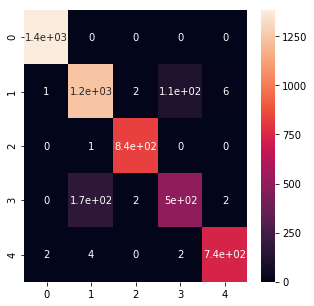

In [269]:
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
sn.heatmap(df, annot=True)